In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
data_directory = './ecephys_cache' # must be updated to a valid directory in your filesystem

manifest_path = os.path.join(data_directory, "manifest.json")

In [3]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [5]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))

Total number of sessions: 58


In [7]:
filtered_sessions = sessions[(sessions.full_genotype.str.find('Sst') > -1) & \
                             (sessions.session_type == 'brain_observatory_1.1') & \
                             (['VISp' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]

print(len(filtered_sessions))
filtered_sessions.head()

6


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."
758798717,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,593,1486,4,"[MGv, MGd, TH, DG, CA1, VISal, nan, SGN, LP, S..."
760693773,2019-10-03T00:00:00Z,738651054,brain_observatory_1.1,110.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,826,2233,6,"[grey, VISrl, nan, VISal, VISp, VISpm, VISam]"


In [8]:
session_id = 715093703  # based on the above filter
session = cache.get_session_data(session_id)

In [11]:
units = cache.get_units()

# Natural Movie One

In [12]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs = stim_epochs[stim_epochs.stimulus_name=="natural_movie_one"]
stim_pres_ids = session.get_stimulus_table(['natural_movie_one']).index
stim_epochs

,start_time,stop_time,duration,stimulus_name,stimulus_block
9,2835.861733,3136.112583,300.25085,natural_movie_one,4
25,7693.936523,7994.187283,300.25076,natural_movie_one,12


natual movie 1 is 30 seconds per clip repeated 10 times per block, natural movie 2 is 120 second per clip repeated 5 times per block.

In [13]:
unit_ids = units[(units.ecephys_structure_acronym=="VISp") & (units.specimen_id==filtered_sessions.specimen_id[session_id])].index
unit_ids.shape

(60,)

I have to make my own histogram because the presentationwise spike counts method does it frame by frame.

In [15]:
times = session.presentationwise_spike_times(stimulus_presentation_ids=stim_pres_ids, # is this right? todo
                                             unit_ids=unit_ids)

C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1093: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


In [16]:
times

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
2835.864302,22000,950930985,0.002569
2835.872035,22000,950930407,0.010302
2835.872502,22000,950930964,0.010769
2835.880435,22000,950931517,0.018702
2835.881935,22000,950931254,0.020202
...,...,...,...
7994.181869,66115,950932563,0.027946
7994.183102,66115,950933732,0.029180
7994.183636,66115,950932102,0.029713


In [17]:
num_bins = 200
stim_length = 30  # seconds for natural movie one
stim_range = np.array([0, stim_length])
trials = np.zeros((20, num_bins, len(unit_ids)))  # stimulus was presented 20 times
bin_edges = np.linspace(0, stim_length, num_bins + 1)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
bin_width = bin_edges[1] - bin_edges[0]

for j, unit_id in enumerate(unit_ids):
    # 1st block where nat 1 is shown, it is shown 10 times in each block
    presentations1 = stim_epochs.iloc[0].start_time + np.linspace(0, stim_epochs.iloc[0].duration, 10)
    # 2nd block
    presentations2 = stim_epochs.iloc[1].start_time + np.linspace(0, stim_epochs.iloc[1].duration, 10)
    presentations = np.concatenate([presentations1, presentations2])
    for i, start in enumerate(presentations):
        times_ij = times[(times.unit_id==unit_id) & (start < times.index) & (times.index < (start + stim_length))].index
        unit_counts, _ = np.histogram(times_ij, num_bins, range=start + stim_range)
        trials[i, :, j] = unit_counts

In [18]:
trials.shape

(20, 200, 60)

In [19]:
avgCounts = np.mean(trials, axis=0)
avgCounts

array([[1.85, 1.5 , 0.6 , ..., 0.2 , 0.  , 0.1 ],
       [2.65, 1.75, 0.7 , ..., 0.3 , 0.1 , 0.  ],
       [2.05, 1.45, 0.95, ..., 0.25, 0.  , 0.  ],
       ...,
       [1.75, 1.4 , 0.2 , ..., 0.15, 0.4 , 0.05],
       [0.8 , 0.8 , 0.25, ..., 0.45, 0.15, 0.  ],
       [1.65, 1.15, 0.35, ..., 0.3 , 0.15, 0.05]])

<BarContainer object of 200 artists>

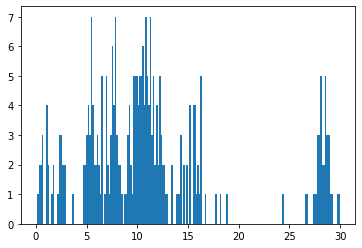

In [20]:
%matplotlib inline
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
bin_width = bin_edges[1] - bin_edges[0]
plt.bar(bin_centers, trials[0, :, 2], width=bin_width)

- classify gradients
- singular value spectrum
- mutual information (define response as a specific classification) (if time)
- use the 4 different videos (nat 1, nat 3 (1), nat 3 (2), nat 3 (3)) and try to cluster the responses in PCA space

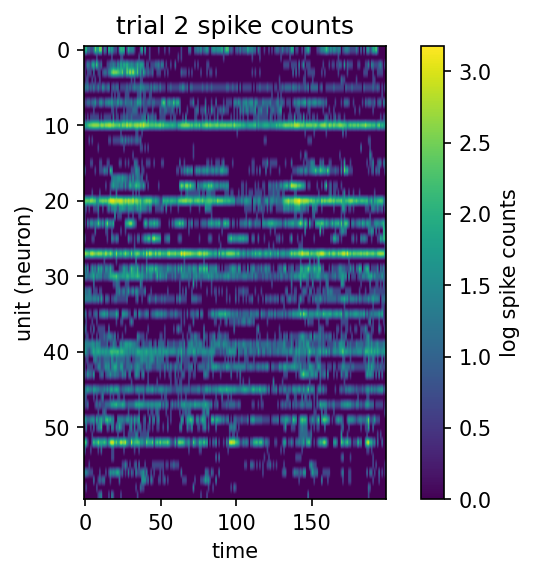

In [22]:
trial=2
plt.figure(dpi=150)
plt.ylabel("unit (neuron)")
plt.xlabel("time")
plt.imshow(np.log(trials[trial].T + 1), aspect=5)
plt.title(f"trial {trial} spike counts")
plt.colorbar(label="log spike counts")

# Static Grating Classification
## Controlled orientation decoding

In [24]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs = stim_epochs[stim_epochs.stimulus_name=="static_gratings"]
stim_epochs

,start_time,stop_time,duration,stimulus_name,stimulus_block
17,5381.988653,5862.389913,480.40126,static_gratings,8
23,7183.510123,7663.911423,480.40130,static_gratings,11
29,8594.688933,9135.140323,540.45139,static_gratings,14


In [80]:
stims = session.get_stimulus_table(['static_gratings'])
stims = stims[stims.orientation!='null']

In [106]:
filtered_stims = stims[(stims.phase=="0.0") & (stims.spatial_frequency=="0.04")]
filtered_stims

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,
49437,0.8,60,0.0,"[250.0, 250.0]",0.04,5383.239686,8,static_gratings,5383.489905,0.250219,4792
49443,0.8,30,0.0,"[250.0, 250.0]",0.04,5384.740946,8,static_gratings,5384.991147,0.250201,4798
49448,0.8,90,0.0,"[250.0, 250.0]",0.04,5385.991973,8,static_gratings,5386.242184,0.250211,4803
49456,0.8,30,0.0,"[250.0, 250.0]",0.04,5387.993653,8,static_gratings,5388.243862,0.250209,4798
49460,0.8,30,0.0,"[250.0, 250.0]",0.04,5388.994487,8,static_gratings,5389.244699,0.250211,4798
...,...,...,...,...,...,...,...,...,...,...,...
70301,0.8,150,0.0,"[250.0, 250.0]",0.04,9113.372172,14,static_gratings,9113.622370,0.250199,4838
70314,0.8,150,0.0,"[250.0, 250.0]",0.04,9116.624855,14,static_gratings,9116.875054,0.250199,4838
70361,0.8,150,0.0,"[250.0, 250.0]",0.04,9128.384686,14,static_gratings,9128.634885,0.250199,4838


In [107]:
filtered_stims.shape

(294, 11)

In [163]:
num_bins = 10
stim_duration = filtered_stims.duration.min()  # minimum so that none of the recording periods are overlapping
bin_edges = np.linspace(0, stim_duration, num_bins + 1)
counts = session.presentationwise_spike_counts(bin_edges=bin_edges,
                                               stimulus_presentation_ids=filtered_stims.index,
                                               unit_ids=unit_ids)

In [164]:
oris = np.unique(filtered_stims.orientation).astype(int)
oris

array([  0,  30,  60,  90, 120, 150])

In [165]:
avg_resp = np.mean(counts, axis=0)

C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if sys.path[0] == '':


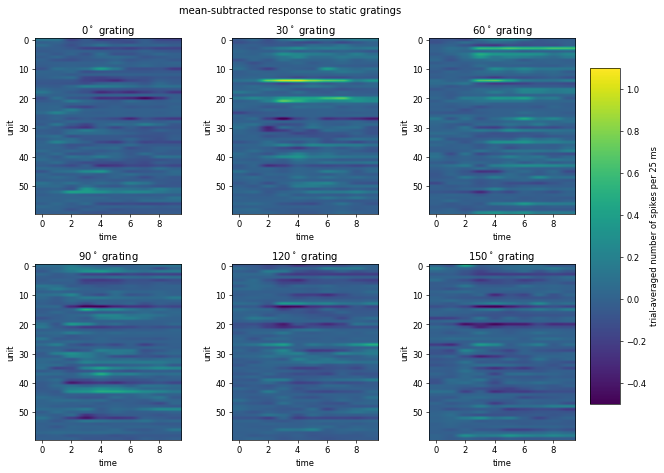

In [166]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8), dpi=60)
fig.suptitle("mean-subtracted response to static gratings")
for i, ori in enumerate(oris):
    plt.subplot(2, 3, i+1)
    idxs = filtered_stims[filtered_stims.orientation==ori].index
    plt.ylabel("unit")
    plt.xlabel("time")opifhspof
    im = plt.imshow((np.mean(counts.loc[idxs], axis=0).T - avg_resp), aspect=0.2, vmin=-0.5, vmax=1.1)
    plt.title(f"{ori}$^\circ$ grating")
cbar_ax = fig.add_axes([1.0, 0.15, 0.05, 0.7])
fig.colorbar(mappable=im, label=f"trial-averaged number of spikes per {int(1000 * stim_duration / num_bins)} ms", cax=cbar_ax)
plt.tight_layout()
plt.show()

## Data preprocessing and PCA

In [167]:
np.random.seed(10)

In [168]:
Xall = np.reshape(np.array(counts), (counts.shape[0], num_bins * len(unit_ids)))
labels = np.array(list(filtered_stims.orientation))

# train test split
train_frac = 0.7
train_idxs = np.array([], dtype=int)
test_idxs = np.array([], dtype=int)
for label in np.unique(labels):
    matches = np.nonzero(labels == label)[0]
    np.random.shuffle(matches)
    train_idxs = np.concatenate([train_idxs, matches[:int(train_frac * len(matches))]])
    test_idxs = np.concatenate([test_idxs, matches[int(train_frac * len(matches)):]])

In [169]:
Xc_train = Xall[train_idxs] - np.mean(Xall[train_idxs], axis=0, keepdims=True)
Xc_test = Xall[test_idxs] - np.mean(Xall[test_idxs], axis=0, keepdims=True)
U, S, Vh = np.linalg.svd(Xc_train, full_matrices=False)

In [170]:
proj_rank = 20
train = (np.diag(S[:proj_rank]) @ U.T[:proj_rank]).T
test = Xc_test @ Vh.T[:, :proj_rank]

<IPython.core.display.Javascript object>


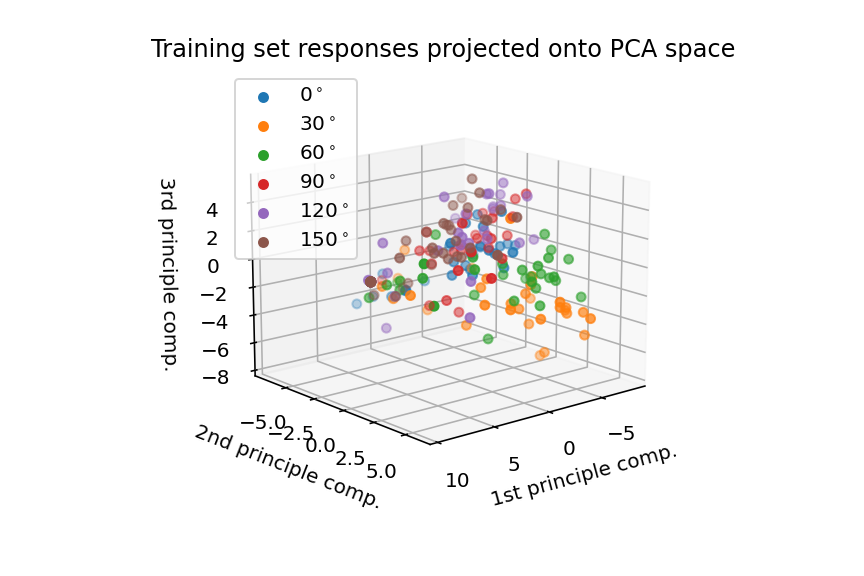

In [171]:
%matplotlib notebook
sample_size = 2000  # all
fig = plt.figure(dpi=120)
ax = fig.gca(projection='3d')
plt.title("Training set responses projected onto PCA space")
# for ori in oris[[1,3]]:
for ori in oris:
    ori_ims = train[np.nonzero(labels[train_idxs]==ori)[0], :3][:sample_size // len(oris)]
    ax.scatter(ori_ims[:, 0], ori_ims[:, 1], ori_ims[:, 2], label=f"{ori}$^\circ$")
ax.view_init(elev=15, azim=50)
plt.xlabel("1st principle comp.")
plt.ylabel("2nd principle comp.")
ax.set_zlabel("3rd principle comp.")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


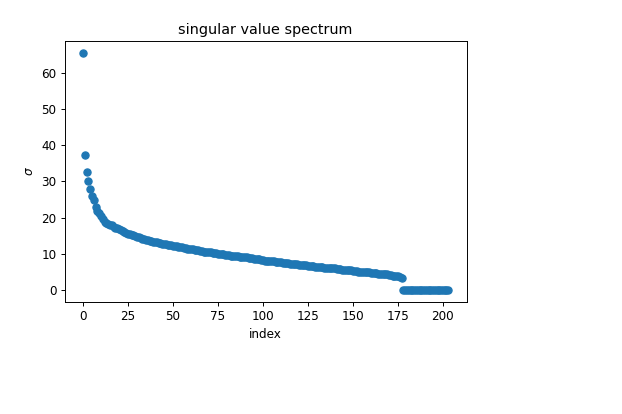

In [172]:
plt.figure()
plt.scatter(np.arange(len(S)), S)
plt.xlabel("index")
plt.ylabel("$\sigma$")
plt.title("singular value spectrum")
plt.show()

In [173]:
len(S), S[177], S[178]

(204, 3.426418457037982, 1.3229318255165724e-14)

# covariance classification

In [206]:
avgs = []
stds = []
train_avg = np.mean(Xc_train, axis=0)
for ori in oris:
    idxs = np.nonzero(labels[train_idxs]==ori)
    avgs.append(np.mean(Xc_train[idxs] - train_avg, axis=0))
    stds.append(np.std(Xc_train[idxs] - train_avg, axis=0))

In [207]:
def covar_classify(Xc, avgs, oris):
    pre = []
    for response in Xc:
        covars = []
        for avg, std in zip(avgs, stds):
            covars.append(np.mean(avg.T @ response))
        ori_idx = np.argmax(covars)
        pre.append(oris[ori_idx])
    return pre

In [271]:
def covar_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, oris):
    fit = covar_classify(Xc_train, avgs, oris)
    train_err = np.sum(fit != labels[train_idxs]) / len(fit)
    
    pre = covar_classify(Xc_test, avgs, oris)
    err = np.sum(pre != labels[test_idxs]) / len(pre)
        
    conf = metrics.confusion_matrix(labels[test_idxs], pre, labels=oris)
    
    %matplotlib inline
    plt.figure()
    plt.imshow(conf)
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(oris)))
    ax.set_yticks(np.arange(len(oris)))
    ax.set_xticklabels(oris)
    ax.set_yticklabels(oris)
    plt.colorbar()
    plt.show()
    
    return train_err, err

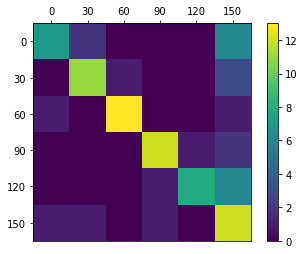

train error: 0.21568627450980393   test error: 0.3


In [209]:
train_err, err = covar_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, oris)
print("train error:", train_err, "  test error:", err)

## max likelihood classification

In [187]:
def max_likelihood_classify(Xc, avgs, stds, oris):
    pre = []
    for response in Xc:
        covars = []
        for avg, std in zip(avgs, stds):
            covars.append(np.mean((avg - response)**2 / (2*(std + 0.01)**2) + np.log(std + 0.01)))
        ori_idx = np.argmin(covars)
        pre.append(oris[ori_idx])

    return pre

In [272]:
def max_likelihood_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, stds, oris):
    fit = max_likelihood_classify(Xc_train, avgs, stds, oris)
    train_err = np.sum(fit != labels[train_idxs]) / len(fit)
    
    pre = max_likelihood_classify(Xc_test, avgs, stds, oris)
    err = np.sum(pre != labels[test_idxs]) / len(pre)
        
    conf = metrics.confusion_matrix(labels[test_idxs], pre, labels=oris)
    
    %matplotlib inline
    plt.figure()
    plt.imshow(conf)
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(oris)))
    ax.set_yticks(np.arange(len(oris)))
    ax.set_xticklabels(oris)
    ax.set_yticklabels(oris)
    plt.colorbar()
    plt.show()
    
    return train_err, err

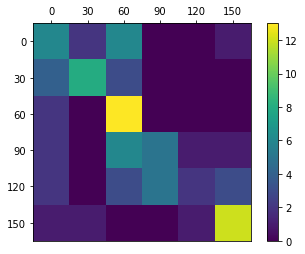

train error: 0.09803921568627451   test error: 0.4888888888888889


In [194]:
train_err, err = max_likelihood_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, stds, oris)
print("train error:", train_err, "  test error:", err)

## SVM Classification of 294
- compare with the STA method
- might try normalizing it so no unit is too dominant

In [45]:
from sklearn import svm
from sklearn import metrics

In [273]:
def svm_evaluate(train, test, labels, train_idxs, test_idxs, oris):
    clf = svm.SVC(decision_function_shape="ovo")
    clf.fit(train, labels[train_idxs])
    
    fit = clf.predict(train)
    train_err = np.sum(fit != labels[train_idxs]) / len(fit)
    
    pre = clf.predict(test)
    err = np.sum(pre != labels[test_idxs]) / len(pre)
        
    conf = metrics.confusion_matrix(labels[test_idxs], pre, labels=oris)
    
    %matplotlib inline
    plt.figure()
    plt.imshow(conf)
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(oris)))
    ax.set_yticks(np.arange(len(oris)))
    ax.set_xticklabels(oris)
    ax.set_yticklabels(oris)
    plt.colorbar()
    plt.show()
    
    return train_err, err

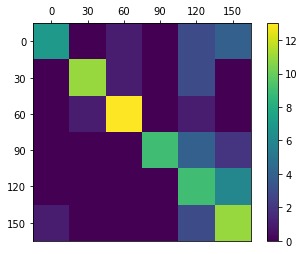

train error: 0.14705882352941177   test error: 0.3333333333333333


In [211]:
train_err, err = svm_evaluate(train, test, labels, train_idxs, test_idxs, oris)
print("train error:", train_err, "  test error:", err)

# Classification of all 6000 gratings
## Get data PCA projections

In [212]:
num_bins = 10
stim_duration = stims.duration.min()  # minimum so that none of the recording periods are overlapping
bin_edges = np.linspace(0, stim_duration, num_bins + 1)
counts = session.presentationwise_spike_counts(bin_edges=bin_edges,
                                               stimulus_presentation_ids=stims.index,
                                               unit_ids=unit_ids)

In [213]:
Xall = np.reshape(np.array(counts), (counts.shape[0], num_bins * len(unit_ids)))
labels = np.array(list(stims.orientation))

# train test split
train_frac = 0.7
train_idxs = np.array([], dtype=int)
test_idxs = np.array([], dtype=int)
for label in np.unique(labels):
    matches = np.nonzero(labels == label)[0]
    np.random.shuffle(matches)
    train_idxs = np.concatenate([train_idxs, matches[:int(train_frac * len(matches))]])
    test_idxs = np.concatenate([test_idxs, matches[int(train_frac * len(matches)):]])

In [214]:
Xc_train = Xall[train_idxs] - np.mean(Xall[train_idxs], axis=0, keepdims=True)
Xc_test = Xall[test_idxs] - np.mean(Xall[test_idxs], axis=0, keepdims=True)
U, S, Vh = np.linalg.svd(Xc_train, full_matrices=False)

In [215]:
proj_rank = 20
train = (np.diag(S[:proj_rank]) @ U.T[:proj_rank]).T
test = Xc_test @ Vh.T[:, :proj_rank]

<IPython.core.display.Javascript object>


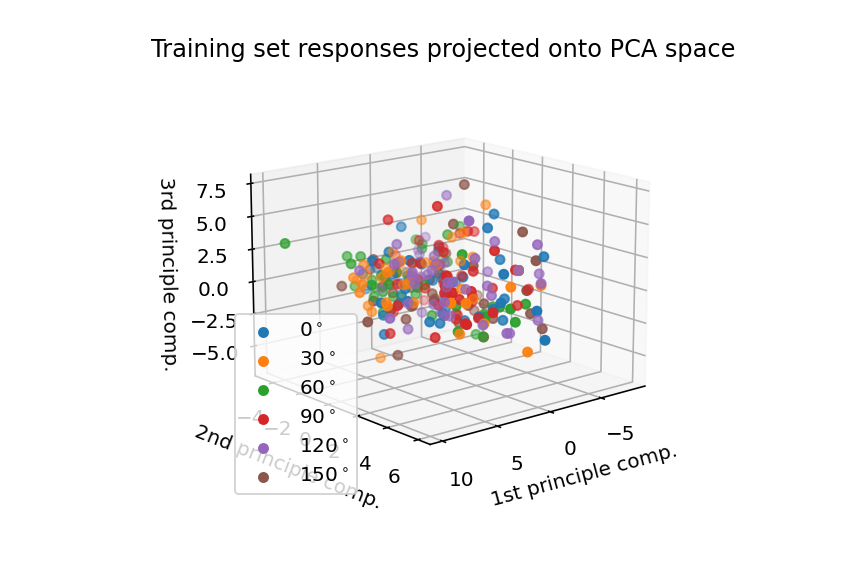

In [216]:
%matplotlib notebook

sample_size = 300
fig = plt.figure(dpi=120)
ax = fig.gca(projection='3d')
plt.title("Training set responses projected onto PCA space")
for ori in oris:
    ori_ims = train[np.nonzero(labels[train_idxs]==ori)[0], :3][:sample_size // len(oris)]
    ax.scatter(ori_ims[:, 0], ori_ims[:, 1], ori_ims[:, 2], label=f"{ori}$^\circ$")
ax.view_init(elev=15, azim=50)
plt.xlabel("1st principle comp.")
plt.ylabel("2nd principle comp.")
ax.set_zlabel("3rd principle comp.")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


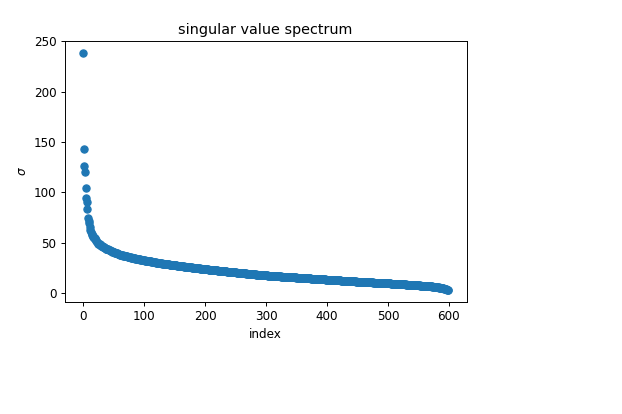

In [218]:
plt.figure()
plt.scatter(np.arange(len(S)), S)
plt.xlabel("index")
plt.ylabel("$\sigma$")
plt.title("singular value spectrum")
plt.show()

# covariance classification

In [220]:
avgs = []
stds = []
train_avg = np.mean(Xc_train, axis=0)
for ori in oris:
    idxs = np.nonzero(labels[train_idxs]==ori)
    avgs.append(np.mean(Xc_train[idxs] - train_avg, axis=0))
    stds.append(np.std(Xc_train[idxs] - train_avg, axis=0))

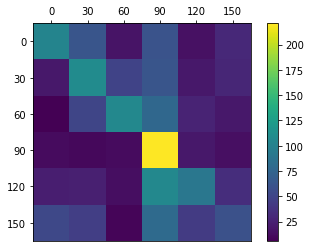

train error: 0.5755041810132808   test error: 0.6045845272206304


In [221]:
train_err, err = covar_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, oris)
print("train error:", train_err, "  test error:", err)

## max likelihood classification

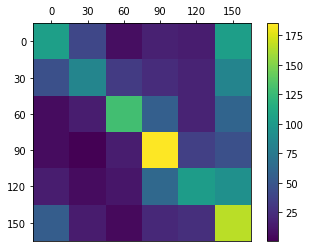

train error: 0.4677816035415642   test error: 0.5570200573065902


In [222]:
train_err, err = max_likelihood_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, stds, oris)
print("train error:", train_err, "  test error:", err)

## SVM

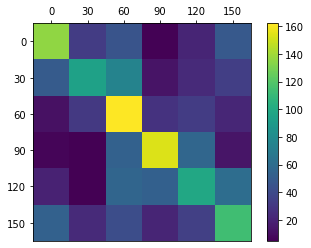

train error: 0.39916379734382684   test error: 0.5644699140401146


In [223]:
train_err, err = svm_evaluate(train, test, labels, train_idxs, test_idxs, oris)
print("train error:", train_err, "  test error:", err)

# Natural Scene Image Classification
## get data and PCA projections

In [381]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs = stim_epochs[stim_epochs.stimulus_name=="natural_scenes"]
stim_epochs

,start_time,stop_time,duration,stimulus_name,stimulus_block
19,5892.415053,6372.832933,480.417880,natural_scenes,9
21,6673.083753,7153.485033,480.401280,natural_scenes,10
27,8024.212413,8552.153375,527.940962,natural_scenes,13


In [382]:
stims = session.get_stimulus_table(["natural_scenes"])
stims

,frame,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,
51353,5,5892.415053,9,natural_scenes,5892.665249,0.250196,4908
51354,114,5892.665249,9,natural_scenes,5892.915445,0.250196,4909
51355,13,5892.915445,9,natural_scenes,5893.165641,0.250196,4910
51356,70,5893.165641,9,natural_scenes,5893.415837,0.250196,4911
51357,26,5893.415837,9,natural_scenes,5893.666049,0.250211,4912
...,...,...,...,...,...,...,...
68222,24,8550.902302,13,natural_scenes,8551.152520,0.250219,5006
68223,107,8551.152520,13,natural_scenes,8551.402739,0.250219,4969
68224,100,8551.402739,13,natural_scenes,8551.652957,0.250219,4924


In [405]:
label_set = np.random.choice(np.arange(118), 118, replace=False)
filtered_stims = stims[list(frame in label_set for frame in stims.frame)]
filtered_stims.shape

(5900, 7)

In [406]:
label_set

array([108,  15,  48,  92,  37,  74,  84,  62,  58, 101,  35,  32,  47,
        80,  40,  68,  88,  86,  71,   9,  61,  72,  73,  98,  27,  44,
        76,  60,   0,  17,  70,  50,  14,  38,  93,   2,  11, 109,  79,
        42,  31,  54,  10,   1, 110, 114,   4,   7,  12,  95,  28,  55,
       106,  63,  18,  89,  59,  53, 103,  64,   5,  65, 100,  96,  56,
        83, 117,  24,  91,  78, 112,  49,  19,  22,  57,  82,  97,  94,
        52, 113,  87,  43,  13,  16,  23,  39,  81,   3,  26,  21, 104,
         6, 105,  51,  69,  34,  30,  36,  66, 107,   8,  99,  20,  85,
       102,  77,  25,  29,  45,  75, 115,  67,  90,  41, 116,  33, 111,
        46])

Each image was shown 50 times

In [407]:
num_bins = 10
stim_duration = filtered_stims.duration.min()  # minimum so that none of the recording periods are overlapping
bin_edges = np.linspace(0, stim_duration, num_bins + 1)
counts = session.presentationwise_spike_counts(bin_edges=bin_edges,
                                               stimulus_presentation_ids=filtered_stims.index,
                                               unit_ids=unit_ids)

In [408]:
Xall = np.reshape(np.array(counts), (counts.shape[0], num_bins * len(unit_ids)))
labels = np.array(list(filtered_stims.frame))

# train test split
train_frac = 0.7
train_idxs = np.array([], dtype=int)
test_idxs = np.array([], dtype=int)
for label in label_set:
    matches = np.nonzero(labels == label)[0]
    np.random.shuffle(matches)
    train_idxs = np.concatenate([train_idxs, matches[:int(train_frac * len(matches))]])
    test_idxs = np.concatenate([test_idxs, matches[int(train_frac * len(matches)):]])

In [409]:
Xc_train = Xall[train_idxs] - np.mean(Xall[train_idxs], axis=0, keepdims=True)
Xc_test = Xall[test_idxs] - np.mean(Xall[test_idxs], axis=0, keepdims=True)
U, S, Vh = np.linalg.svd(Xc_train, full_matrices=False)

In [410]:
proj_rank = 20
train = (np.diag(S[:proj_rank]) @ U.T[:proj_rank]).T
test = Xc_test @ Vh.T[:, :proj_rank]

<IPython.core.display.Javascript object>


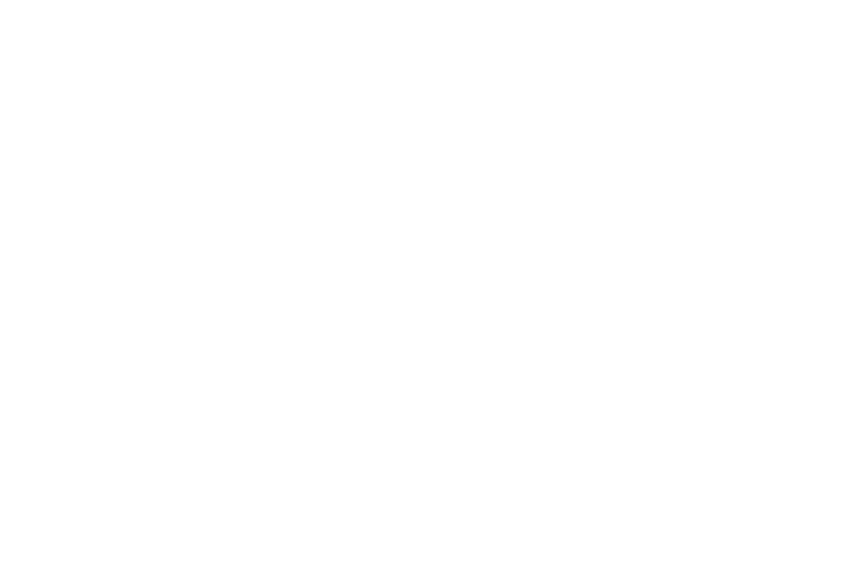

In [411]:
%matplotlib notebook
sample_size = 2000
fig = plt.figure(dpi=120)
ax = fig.gca(projection='3d')
plt.title("Training set responses projected onto PCA space")
# for ori in oris[[1,3]]:
for lab in label_set:
    lab_resp = train[np.nonzero(labels[train_idxs]==lab)[0], :3][:sample_size // len(label_set)]
    ax.scatter(lab_resp[:, 0], lab_resp[:, 1], lab_resp[:, 2], label=f"{lab}")
ax.view_init(elev=15, azim=50)
plt.xlabel("1st principle comp.")
plt.ylabel("2nd principle comp.")
ax.set_zlabel("3rd principle comp.")
plt.legend()
plt.show()

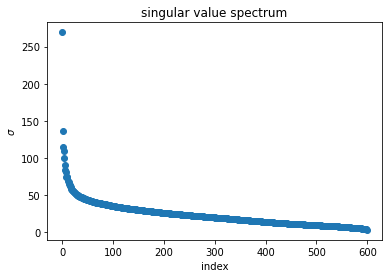

In [413]:
%matplotlib inline
plt.figure()
plt.scatter(np.arange(len(S)), S)
plt.xlabel("index")
plt.ylabel("$\sigma$")
plt.title("singular value spectrum")
plt.show()

In [414]:
S[183], S[184]

(27.39807012163481, 27.332039421667808)

## covariance classification

In [415]:
avgs = []
stds = []
train_avg = np.mean(Xc_train, axis=0)
for lab in label_set:
    idxs = np.nonzero(labels[train_idxs]==lab)
    avgs.append(np.mean(Xc_train[idxs] - train_avg, axis=0))
    stds.append(np.std(Xc_train[idxs] - train_avg, axis=0))

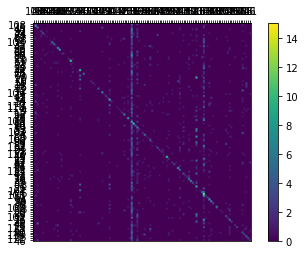

train error: 0.6067796610169491   test error: 0.7836158192090396


In [416]:
train_err, err = covar_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, label_set)
print("train error:", train_err, "  test error:", err)

## max likelihood classification

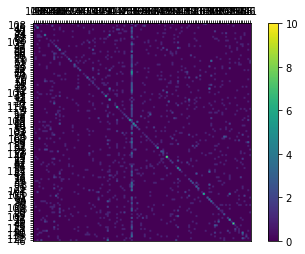

train error: 0.1721549636803874   test error: 0.8632768361581921


In [417]:
train_err, err = max_likelihood_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, stds, label_set)
print("train error:", train_err, "  test error:", err)

## SVM classification

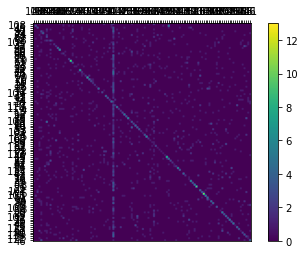

train error: 0.49854721549636805   test error: 0.7870056497175141


In [418]:
train_err, err = svm_evaluate(train, test, labels, train_idxs, test_idxs, label_set)
print("train error:", train_err, "  test error:", err)

# Classification accuracy versus number of images

In [429]:
nums_included = np.logspace(0.4, 2.07, 10, base=10).astype(int)
nums_included

array([  2,   3,   5,   9,  13,  21,  32,  49,  76, 117])

NUM INCLUDED -------  2
COVARIANCE


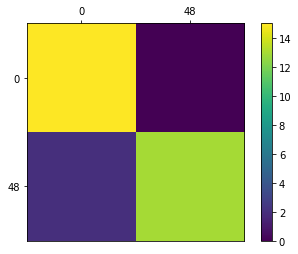

train error: 0.12857142857142856   test error: 0.06666666666666667
MAX LIKELIHOOD


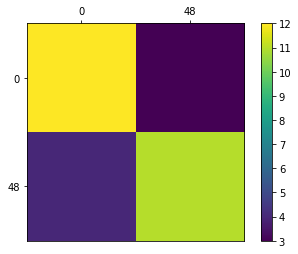

train error: 0.08571428571428572   test error: 0.23333333333333334
SVM


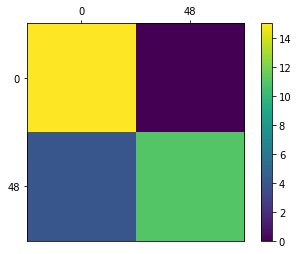

train error: 0.1   test error: 0.13333333333333333
NUM INCLUDED -------  3
COVARIANCE


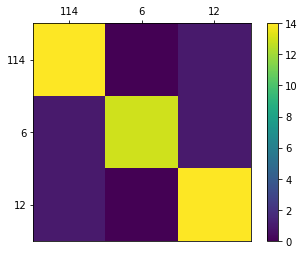

train error: 0.14285714285714285   test error: 0.08888888888888889
MAX LIKELIHOOD


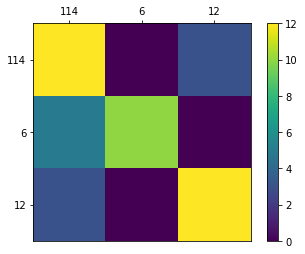

train error: 0.0761904761904762   test error: 0.24444444444444444
SVM


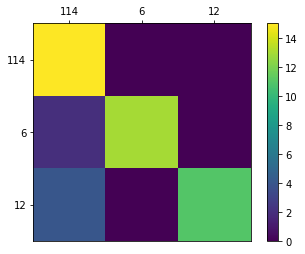

train error: 0.08571428571428572   test error: 0.13333333333333333
NUM INCLUDED -------  5
COVARIANCE


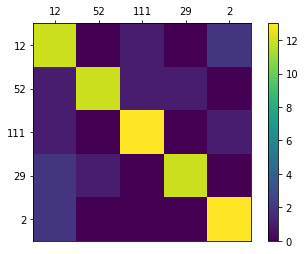

train error: 0.14285714285714285   test error: 0.17333333333333334
MAX LIKELIHOOD


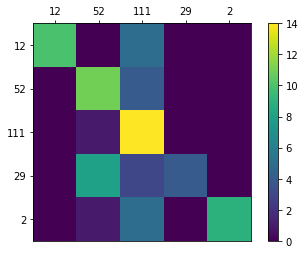

train error: 0.10285714285714286   test error: 0.36
SVM


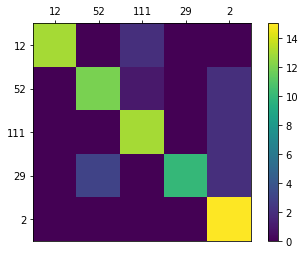

train error: 0.11428571428571428   test error: 0.16
NUM INCLUDED -------  9
COVARIANCE


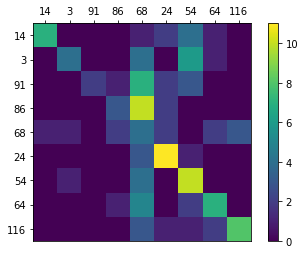

train error: 0.35555555555555557   test error: 0.5851851851851851
MAX LIKELIHOOD


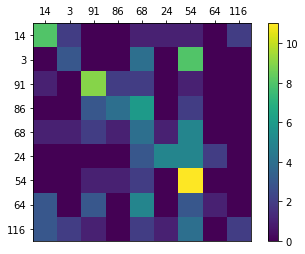

train error: 0.10476190476190476   test error: 0.6518518518518519
SVM


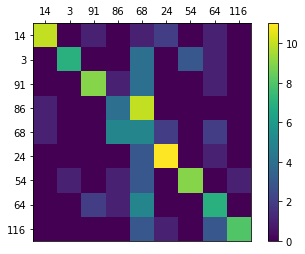

train error: 0.17777777777777778   test error: 0.48148148148148145
NUM INCLUDED -------  13
COVARIANCE


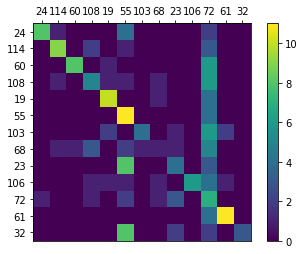

train error: 0.34285714285714286   test error: 0.5538461538461539
MAX LIKELIHOOD


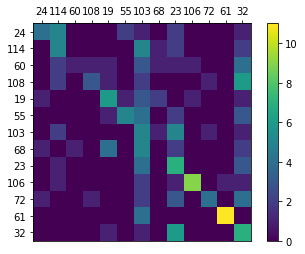

train error: 0.11648351648351649   test error: 0.6564102564102564
SVM


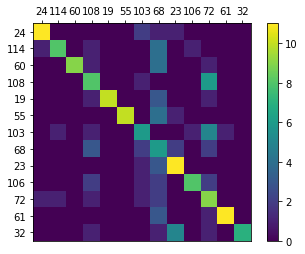

train error: 0.2087912087912088   test error: 0.4153846153846154
NUM INCLUDED -------  21
COVARIANCE


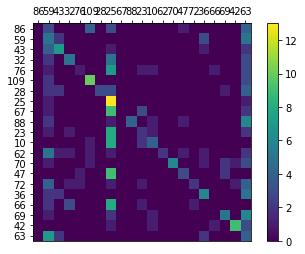

train error: 0.4816326530612245   test error: 0.7111111111111111
MAX LIKELIHOOD


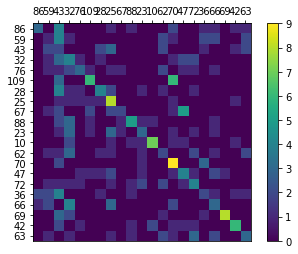

train error: 0.13877551020408163   test error: 0.7174603174603175
SVM


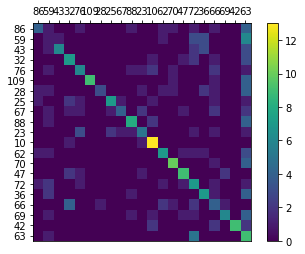

train error: 0.29523809523809524   test error: 0.5523809523809524
NUM INCLUDED -------  32
COVARIANCE


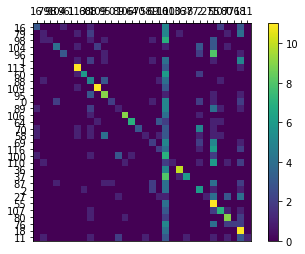

train error: 0.46785714285714286   test error: 0.68125
MAX LIKELIHOOD


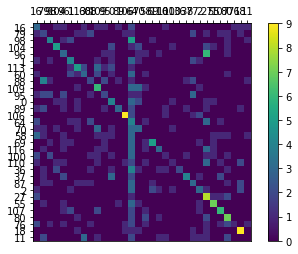

train error: 0.13839285714285715   test error: 0.7458333333333333
SVM


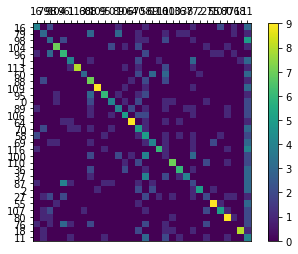

train error: 0.31160714285714286   test error: 0.6583333333333333
NUM INCLUDED -------  49
COVARIANCE


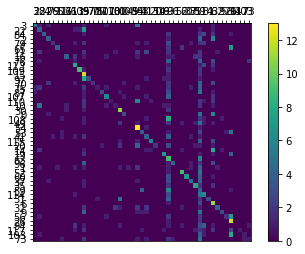

train error: 0.5329446064139942   test error: 0.710204081632653
MAX LIKELIHOOD


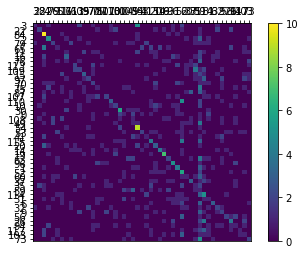

train error: 0.15451895043731778   test error: 0.8258503401360544
SVM


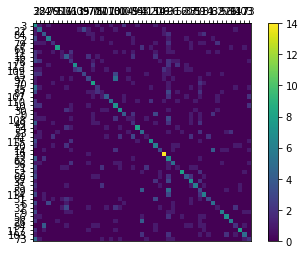

train error: 0.3807580174927114   test error: 0.6843537414965987
NUM INCLUDED -------  76
COVARIANCE


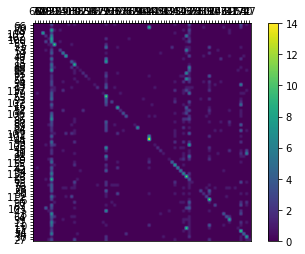

train error: 0.5827067669172933   test error: 0.7885964912280702
MAX LIKELIHOOD


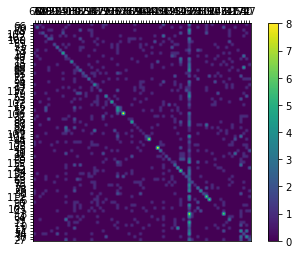

train error: 0.1537593984962406   test error: 0.843859649122807
SVM


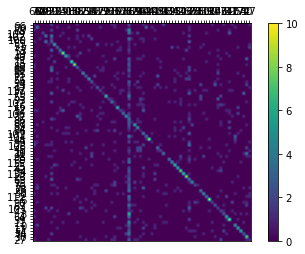

train error: 0.43533834586466164   test error: 0.7368421052631579
NUM INCLUDED -------  117
COVARIANCE


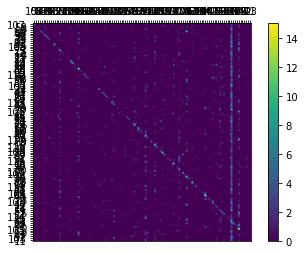

train error: 0.6249084249084249   test error: 0.8091168091168092
MAX LIKELIHOOD


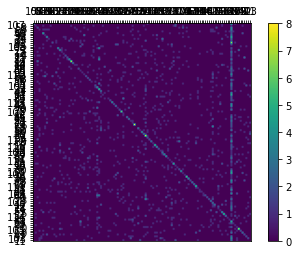

train error: 0.1807081807081807   test error: 0.845014245014245
SVM


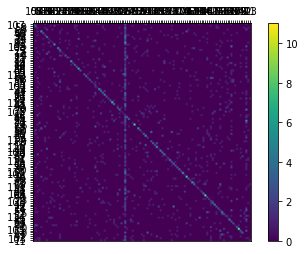

train error: 0.4989010989010989   test error: 0.7903133903133903


In [435]:
errs_cov = []
errs_ml = []
errs_svm = []

for num_included in nums_included:
    print("NUM INCLUDED ------- ", num_included)
    label_set = np.random.choice(np.arange(118), num_included, replace=False)
    filtered_stims = stims[list(frame in label_set for frame in stims.frame)]
    
    stim_duration = filtered_stims.duration.min()  # minimum so that none of the recording periods are overlapping
    bin_edges = np.linspace(0, stim_duration, num_bins + 1)
    counts = session.presentationwise_spike_counts(bin_edges=bin_edges,
                                                   stimulus_presentation_ids=filtered_stims.index,
                                                   unit_ids=unit_ids)
    
    Xall = np.reshape(np.array(counts), (counts.shape[0], num_bins * len(unit_ids)))
    labels = np.array(list(filtered_stims.frame))

    # train test split
    train_frac = 0.7
    train_idxs = np.array([], dtype=int)
    test_idxs = np.array([], dtype=int)
    for label in label_set:
        matches = np.nonzero(labels == label)[0]
        np.random.shuffle(matches)
        train_idxs = np.concatenate([train_idxs, matches[:int(train_frac * len(matches))]])
        test_idxs = np.concatenate([test_idxs, matches[int(train_frac * len(matches)):]])
        
    Xc_train = Xall[train_idxs] - np.mean(Xall[train_idxs], axis=0, keepdims=True)
    Xc_test = Xall[test_idxs] - np.mean(Xall[test_idxs], axis=0, keepdims=True)
    U, S, Vh = np.linalg.svd(Xc_train, full_matrices=False)

    proj_rank = 20
    train = (np.diag(S[:proj_rank]) @ U.T[:proj_rank]).T
    test = Xc_test @ Vh.T[:, :proj_rank]

    avgs = []
    stds = []
    train_avg = np.mean(Xc_train, axis=0)
    for lab in label_set:
        idxs = np.nonzero(labels[train_idxs]==lab)
        avgs.append(np.mean(Xc_train[idxs] - train_avg, axis=0))
        stds.append(np.std(Xc_train[idxs] - train_avg, axis=0))

    print("COVARIANCE")
    train_err, err = covar_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, label_set)
    errs_cov.append(err)
    print("train error:", train_err, "  test error:", err)

    print("MAX LIKELIHOOD")
    train_err, err = max_likelihood_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, stds, label_set)
    errs_ml.append(err)
    print("train error:", train_err, "  test error:", err)

    print("SVM")
    train_err, err = svm_evaluate(train, test, labels, train_idxs, test_idxs, label_set)
    errs_svm.append(err)
    print("train error:", train_err, "  test error:", err)

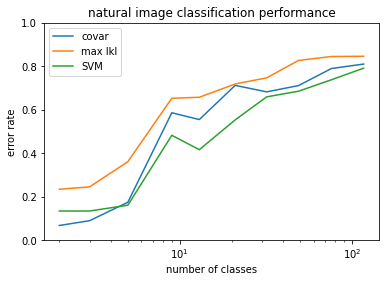

In [437]:
plt.figure()
plt.plot(nums_included, errs_cov, label="covar")
plt.plot(nums_included, errs_ml, label="max lkl")
plt.plot(nums_included, errs_svm, label="SVM")
plt.ylim([0, 1])
plt.ylabel("error rate")
plt.xlabel("number of classes")
plt.title("natural image classification performance")
plt.semilogx()
plt.legend()
plt.show()